In [69]:
import nltk
import numpy as np
import pandas as pd
import json
from tqdm import tqdm
import re
import wordcloud
import matplotlib.pyplot as plt
import heapq

# Text analysis
Analyzing the terms used in the overviews of movies for each genre will provide insights into the differences and similarities between the genres.

In [70]:
def load_json_data(movie_data_path, genre_data_path):
    """
    Loads the JSON data from the given file paths and returns the JSON objects.
    """
    movie_data_path = 'final_movie_data.json'
    genre_data_path = "movie_genres.json"
    movie_json_objects = []
    genre_json_objects = []

    with open(movie_data_path, 'r') as file:
        for line in tqdm(file, desc='Reading JSON'):
            json_object = json.loads(line)
            movie_json_objects.append(json_object)

    with open(genre_data_path, 'r') as file:
        for line in file:
            json_object = json.loads(line)
            genre_json_objects.append(json_object)
    
    return movie_json_objects, genre_json_objects

In [71]:
def json_to_dataframe(movie_json_objects, genre_json_objects):
    """
    Converts the JSON objects to pandas dataframes and sets the genre_id as the index for the genres dataframe.
    Also removes movies with no genres and movies with multiple genres.
    """
    movies_df = pd.json_normalize(movie_json_objects)
    genres_df = pd.json_normalize(genre_json_objects)

    genres_df.set_index("genre_id", inplace=True)
    empty_genres = movies_df[movies_df['combined_genres'].apply(lambda x: len(x) == 0)]
    multiple_genres = movies_df[movies_df['combined_genres'].apply(lambda x: len(x) > 1)]
    movies_df = movies_df.drop(empty_genres.index)
    movies_df = movies_df.drop(multiple_genres.index)
    movies_df = movies_df.reset_index(drop=True)

    return movies_df, genres_df

In [72]:
def get_genres(movies_df, genres_df):
    """
    Adds the genre names to the movies dataframe by loading the genre names from the genres dataframe.
    """
    movies_df["genre"] = genres_df.loc[movies_df["combined_genres"].apply(lambda x: x[0]), "genre_name"].values

In [73]:
def seperate_by_genre(movies_df):
    """
    Seperates the movies dataframe into multiple dataframes based on the genre.
    """
    genre_dfs = {}
    for genre in movies_df["genre"].unique():
        genre_dfs[genre] = movies_df[movies_df["genre"] == genre]
    return genre_dfs

In [74]:
def combine_overviews(genre_dfs):
    """
    Combines the overviews from multiple genre dataframes into a single overview for each genre.
    """
    combined_overviews = {}

    for genre, df in genre_dfs.items():
        overviews = df["overview"].tolist()
        combined_overview = " ".join(overviews)
        combined_overviews[genre] = combined_overview
    
    return combined_overviews

In [75]:
# Define functions for tokeniizing

def stem(word):
     regexp = r'^(.*?)(ing|ly|ed|ious|ies|ive|es|s|ment)?$'
     stem, suffix = re.findall(regexp, word)[0]
     return stem

stemmer = nltk.PorterStemmer()

stop_words = set(nltk.corpus.stopwords.words('english'))

def tokenize_text(text):
    tokens = nltk.word_tokenize(text)
    # Exlcude punctuation, urls, symbols and numbers using isalpha() method
    tokens = [stemmer.stem(token.lower()) for token in tokens if token.isalpha()]
    #tokens = [token.lower() for token in tokens if token.isalpha()]
    #tokens = sorted(set(tokens))

    filtered_tokens = [token for token in tokens if token not in stop_words]

    return filtered_tokens

In [76]:
# Define functions for TF-IDF

def term_frequency(tokens : list):
    # Find the frequency of each token
    frequency = nltk.FreqDist(tokens)
    # Find the total number of tokens
    total_tokens = len(tokens)
    # Find the frequency of each token
    term_frequency = {token : frequency[token] / total_tokens for token in frequency}
    return term_frequency

def inverse_document_frequency(genre_tokens : dict):
    documents = genre_tokens.values()
    # Find the number of documents
    number_of_documents = len(documents)
    # Find the number of documents containing each token
    document_frequency = {}
    for document in documents:
        for token in set(document):
            if token not in document_frequency:
                document_frequency[token] = 1
            else:
                document_frequency[token] += 1
    # Find the inverse document frequency of each token
    inverse_document_frequency = {token : np.log10(number_of_documents / document_frequency[token]) for token in document_frequency}
    return inverse_document_frequency

def tf_idf(term_frequency : dict, inverse_document_frequency : dict):
    # Find the TF-IDF score of each token
    tf_idf = {token : term_frequency[token] * inverse_document_frequency[token] for token in term_frequency}
    return tf_idf

def get_genre_tf_idf(genre_tokens : dict):
    # Find the term frequency of each token in each genre
    genre_term_frequencies = {genre : term_frequency(tokens) for genre, tokens in genre_tokens.items()}
    # Find the inverse document frequency of each token in each genre
    genre_inverse_document_frequencies = inverse_document_frequency(genre_tokens)
    # Find the TF-IDF score of each token in each genre
    genre_tf_idf = {genre : tf_idf(genre_term_frequencies[genre], genre_inverse_document_frequencies) for genre in genre_tokens}
    return genre_tf_idf

In [77]:
# Define function for creating a word cloud
def create_word_cloud(tokens : list):
    # Find the frequency of each token
    frequency = nltk.FreqDist(tokens)
    # Create a word cloud
    cloud = wordcloud.WordCloud(width = 800, height = 400, background_color = "white").generate_from_frequencies(frequency)
    return cloud

# Define a function for plotting the word cloud
def plot_word_cloud(cloud : wordcloud.WordCloud, genre):
    plt.figure(figsize = (6, 3))
    plt.imshow(cloud, interpolation = "bilinear")
    plt.axis("off")
    plt.title(f"Genre: {genre}")

def plot_genre_clouds(genre_tokens : dict):
    for genre, overview in genre_tokens.items():
        word_cloud = create_word_cloud(overview)
        plot_word_cloud(word_cloud, genre)

def plot_genre_clouds_in_single_figure(genre_tokens : dict):
    plt.figure(figsize = (24, 24))

    i = 0
    for genre, overview in genre_tokens.items():
        plt.subplot(5, 4, i+1)
        plt.imshow(create_word_cloud(overview))
        plt.axis("off")
        plt.title(f"Genre: {genre}", fontsize=24)
        i += 1
    
    plt.tight_layout()
    plt.show()

In [78]:
# Load the json data
movie_json_objects, genre_json_objects = load_json_data("final_movie_data.json", "movie_genres.json")

# Create and format dataframes from the data
movies_df, genres_df = json_to_dataframe(movie_json_objects, genre_json_objects)

Reading JSON: 199897it [00:09, 21516.85it/s]


In [79]:
# Add the genre names to the movies dataframe
get_genres(movies_df, genres_df)

# Seperate the movies dataframe into multiple dataframes based on the genre
genre_dfs = seperate_by_genre(movies_df)

In [80]:
num_genres = len(list(genre_dfs.keys()))
print(f"Number of genres: {num_genres}")

Number of genres: 19


In [81]:
# Print the number of movies under each genre
lengths = {genre: len(df) for genre, df in genre_dfs.items()}
for genre, df in genre_dfs.items():
    print(f"Number of movies in genre {genre}: {len(df)}")

Number of movies in genre Comedy: 8751
Number of movies in genre Drama: 14391
Number of movies in genre Thriller: 1688
Number of movies in genre Documentary: 35737
Number of movies in genre Music: 6057
Number of movies in genre Animation: 5580
Number of movies in genre Horror: 6508
Number of movies in genre Western: 174
Number of movies in genre Fantasy: 404
Number of movies in genre Action: 971
Number of movies in genre TV Movie: 101
Number of movies in genre History: 173
Number of movies in genre Science Fiction: 1178
Number of movies in genre Mystery: 265
Number of movies in genre Family: 510
Number of movies in genre Romance: 660
Number of movies in genre Crime: 335
Number of movies in genre Adventure: 177
Number of movies in genre War: 65


### There is a large difference in the number of movies per genre. The distribution of movie numbers can be seen on the plot below.

In [82]:
def plot_genre_lengths(genre_dfs : dict):
    # Get the lengths of each DataFrame
    lengths = [len(df) for df in genre_dfs.values()]

    fontsize = 16
    # Plot the lengths
    plt.figure(figsize=(12, 6))
    plt.bar(genre_dfs.keys(), lengths)
    plt.xlabel("Genre", fontsize=fontsize)
    plt.ylabel("Number of Movies", fontsize=fontsize)
    plt.title("Number of Movies in Each Genre", fontsize=20)
    plt.xticks(rotation=45)
    plt.show()

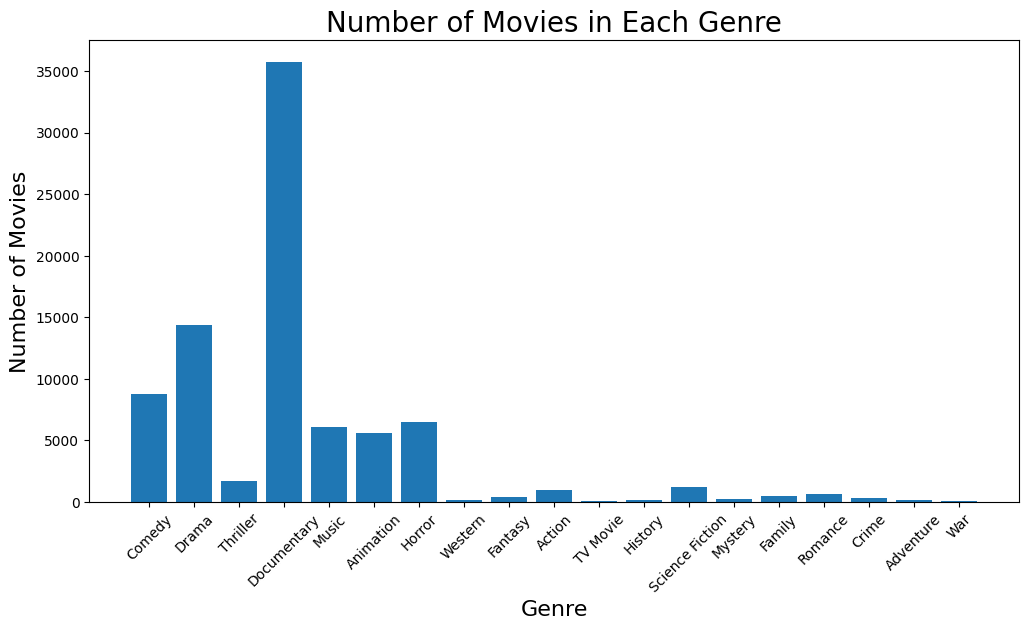

In [83]:
plot_genre_lengths(genre_dfs)

### Since the differnce in number of movies is so large, trying to gain insights about the genre "war"'s TF-IDF scores will have been heavily influenced by other genres with more movies in them, making the impact from the genre itself very small. To avoid this, only genres with more than 1000 movies will be included.

In [84]:
genre_dfs = {genre: df for genre, df in genre_dfs.items() if len(df) >= 1000}
num_genres = len(list(genre_dfs.keys()))
print(f"Number of genres: {num_genres}")

Number of genres: 8


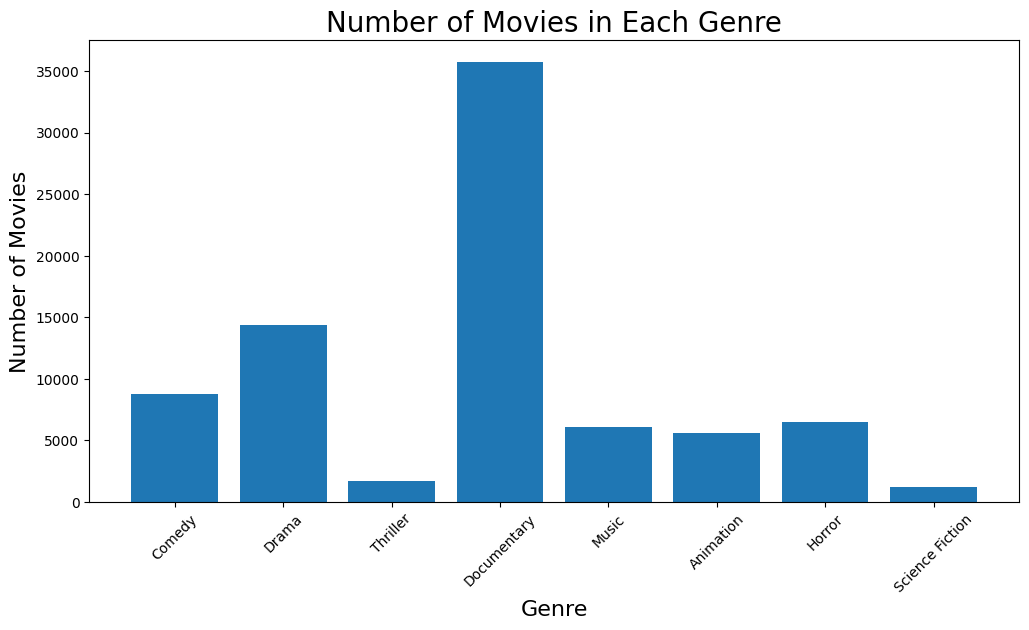

In [85]:
plot_genre_lengths(genre_dfs)

### While "Documentary" still contains many more movies than the other categories, the distribution looks a lot more equal across the other genres.
### Now we can tokenize the stemmed data and calcutate the term frequency, inverse document frequency and the TF-IDF scores.

In [86]:
# Combine the overviews of the movies in each genre
combined_overviews = combine_overviews(genre_dfs)

In [87]:
genre_tokens = {genre: tokenize_text(overview) for genre, overview in tqdm(combined_overviews.items(), desc='Tokenizing')}

Tokenizing: 100%|██████████| 8/8 [01:05<00:00,  8.14s/it]


In [122]:
# Get the genre term frequencies and the genre TF-IDF
genre_tfs = {genre: term_frequency(tokens) for genre, tokens in genre_tokens.items()}
genre_tf_idfs = get_genre_tf_idf(genre_tokens)

### Now we'll make some wordclouds to examine some of the top words from each genre in terms of term frequency and TF-IDF.

In [119]:
# Define functions for plotting worclouds of term frequencies and TF-IDF

def plot_top_n_score(genre_values : dict, top_n : int, title : str):
    wordclouds = {}
    for genre, tf_idfs in genre_values.items():
        top = heapq.nlargest(top_n, tf_idfs, key=tf_idfs.get)
        text = " ".join(top)
        wordclouds[genre] = wordcloud.WordCloud(width=800, height=400, background_color="white").generate(text)
    
    plt.figure(figsize=(24, 24))
    for i, (genre, cloud) in enumerate(wordclouds.items()):
        plt.subplot(5, 4, i+1)
        plt.imshow(cloud)
        plt.axis("off")
        plt.title(f"Genre: {genre}", fontsize=24)
    
    plt.tight_layout()
    plt.show()

## The top 10 words in terms of term frequency for each genre

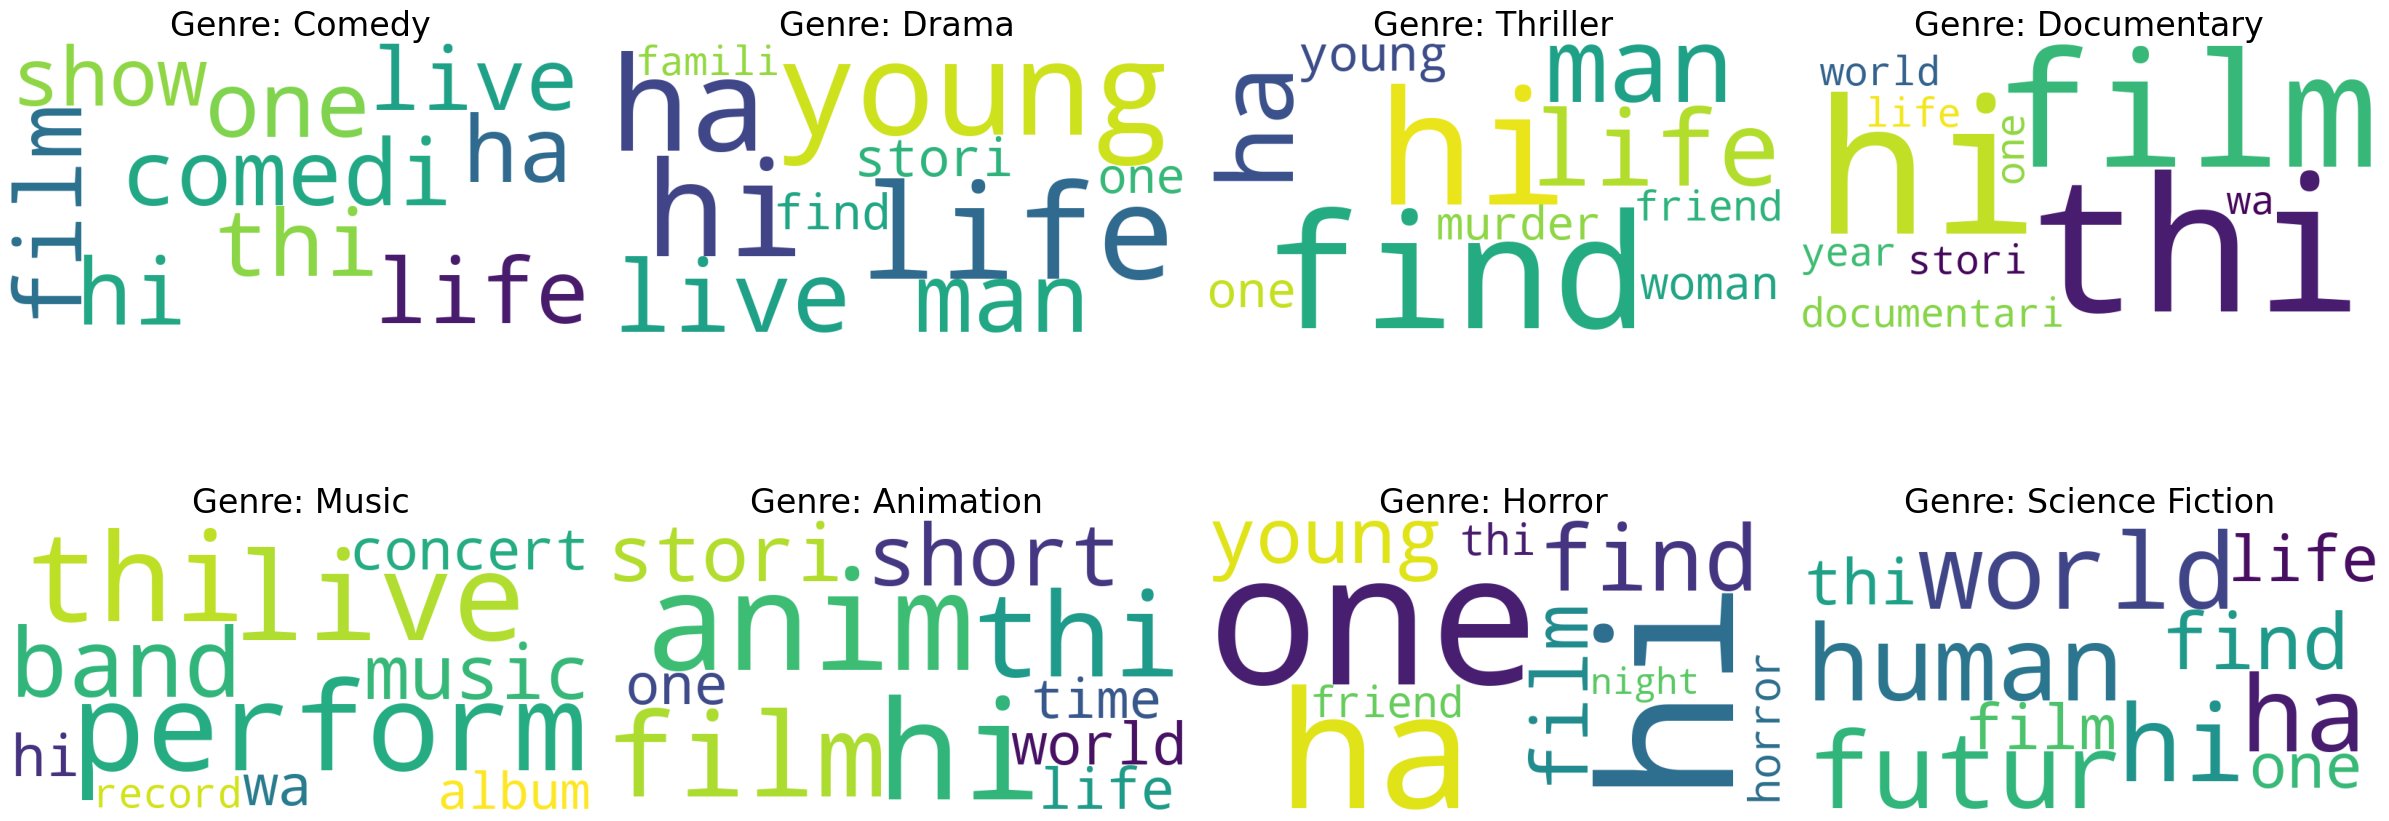

In [120]:
plot_top_n_score(genre_tfs, 10, "Top 10 tokens with highest term frequency for each genre")

### These terms tell us something about each genre, but considering the length of the total overviews, some of them do not give much information. For example, the "Horror" genre, mostly has words like "find", "one", and "young". The only two words that would generally be associated with a horror movie are the words "night" and "horror". Similarly, "Thriller" really only contains the words "find" and "murder" which could be characteristic for it. The other genres contain words that make sense for the genre, but might not be the most important ones, like "film" for "Documentary" likely comes from a common segment in the overviews similar to "This film is --". To get some words that are more defining for the genre, we will look at the TF-IDF, where the inverse document frequency has been calculated by treating each genre's combined overview as a seperate document.

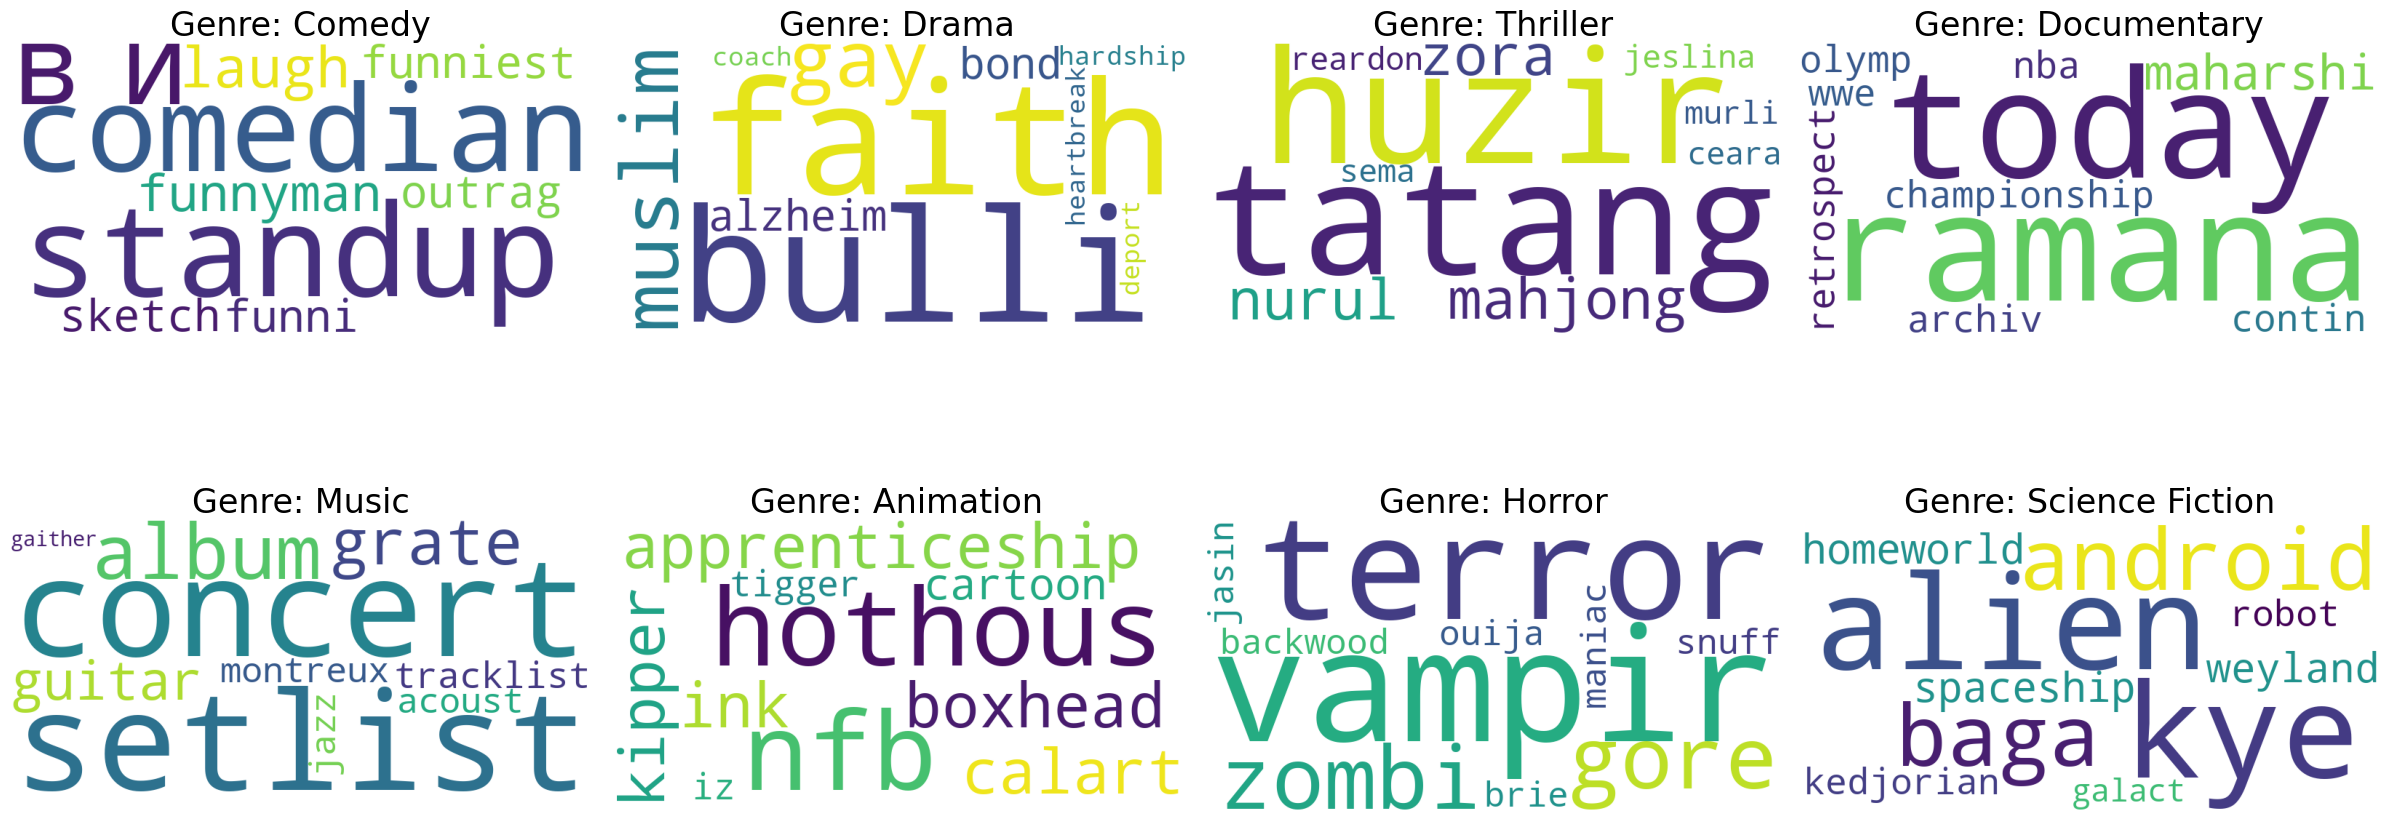

In [121]:
plot_top_n_score(genre_tf_idfs, 10, "Top 10 tokens with highest TF-IDF score for each genre")

### In this figure we see terms which are easier to imagine describing the genre than the term frequencies before. The "Horror" genre is now full of words which characterize this genre. The "Thriller" genre seems to be full of nonsensical words, but upon closer inspection, these words are names of characters that appear many times in the movie's overview, scaling the frequency torwards displaying these rare names rather than terms that define the genre. An argument could be made that calculating the inverse document frequency using each genre as a document is not a good idea. Therefore, below we will calculate TF-IDF scores anew with each movie being a seperate document, and then spliting by genre after.

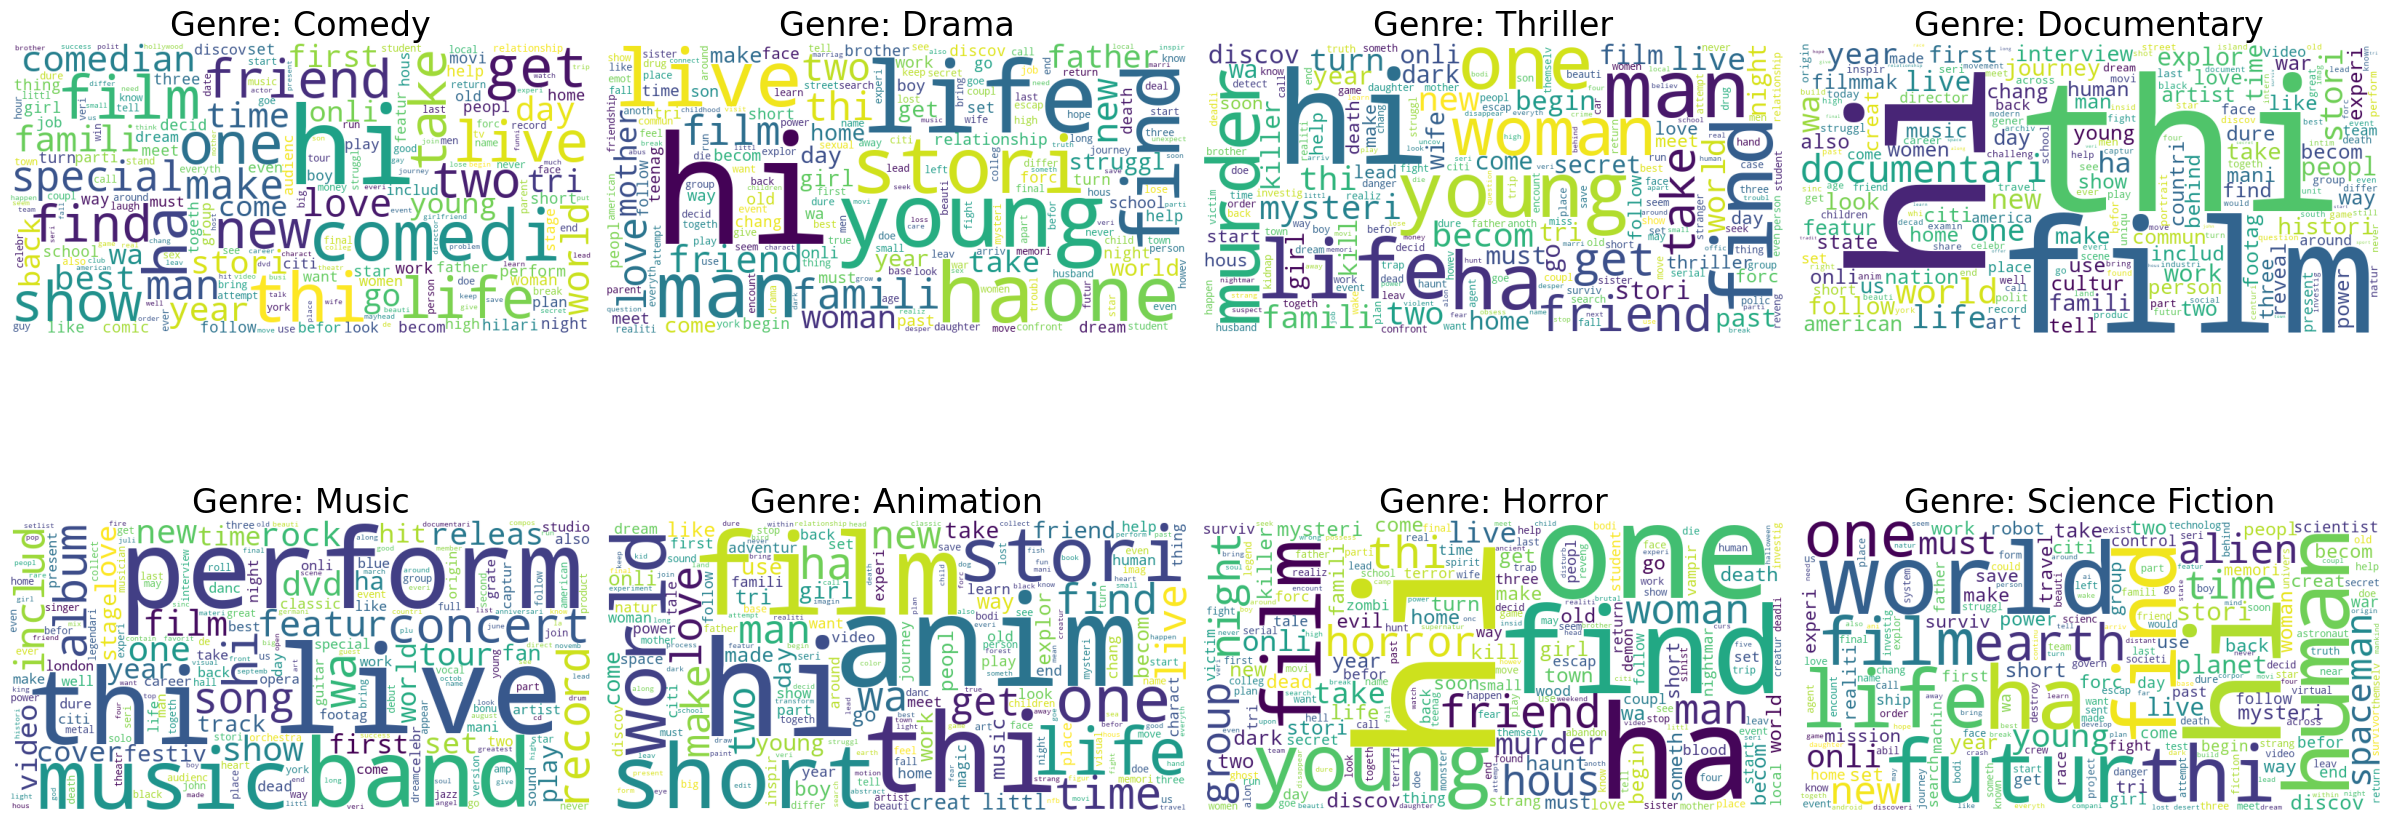

In [92]:
plot_genre_clouds_in_single_figure(genre_tokens)